# k-Means

## Seoul AI Meetup, July 22

Martin Kersner, <m.kersner@gmail.com>

In [1]:
from __future__ import division
import numpy as np
import scipy
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

## Theory 

https://en.wikipedia.org/wiki/K-means_clustering

* Unsupervised learning
* Clustering algorithm
* Iterative technique
* **Does not guarantee convergence to optimal solution.**

### Algorithm

0. Initialize $k$ centroids (= cluster centers).
1. Assignment step
    * Assign each observation (= data record) to the **closest** centroid.
2. Update step
    * Compute new centroids (using $mean$) from assigned observations.
3. Repeat step 2 and 3 until convergence

### Intitialization

* Randomly (within data domain)
* [k-Means++](https://en.wikipedia.org/wiki/K-means%2B%2B)

In [2]:
# Modified version of https://stackoverflow.com/a/5468119
def kmeanspp(X, K):
    C = X[0:1, :] # the first cluster equals to the first data point
    
    for k in range(1, K):
        D2 = scipy.array([min([scipy.inner(C[c_idx, :]-x,C[c_idx, :]-x) for c_idx in range(C.shape[0])]) for x in X])
        
        probs = D2/D2.sum()
        cumprobs = probs.cumsum()
        r = scipy.rand()
        
        for j,p in enumerate(cumprobs):
            if r < p:
                i = j
                break

        C = np.concatenate((C, [X[i, :]]), axis=0)
        
    return C

### Similarity Distance Measures

Selection of similarity distance measure depends on problem you are solving. Examples:

* Euclidean
* Manhattan
* Cosine

<center><img src="https://raw.githubusercontent.com/martinkersner/kmeans-meetup/master/files/simdist.png" /></center>

#### Euclidean Distance

https://en.wikipedia.org/wiki/Euclidean_distance

$d(p, q) = \sqrt{(p_{1}-q_{1})^2+(p_{2}-q_{2})^2 + ... + (p_{n}-q_{n})^2}$

#### Manhattan Distance

https://en.wikipedia.org/wiki/Taxicab_geometry

$D(p, q) = \sum_{i=1}^{n}{|p_{i}-q_{i}|}$

#### Cosine Distance
https://en.wikipedia.org/wiki/Cosine_similarity

$D(p, q) = \frac{\sum_{i=1}^{n}{p_{i}q_{i}}}{\sqrt{\sum_{i=1}^{n}{p_{i}^{2}}}\sqrt{\sum_{i=1}^{n}{q_{i}^{2}}}}$

### Standardize Features

If data are not normalized, features with larger range will dominate over features with smaller range.

**Solution:** Standardize features by removing the mean and scaling to unit variance (e.g. [sklearn.preprocessing.StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html))

```python
X = np.random.rand(100, 3) # generate randomly 100 3-dimensional features
scaler = StandardScaler().fit(X) # standardize features
X_norm = scaler.transform(X)

print(np.mean(X_norm, axis=0)) # mean is 0
>>> [ -4.50750548e-16  -1.59872116e-16   5.72653036e-16]
print(np.std(X_norm, axis=0)) # standard deviation is 1
>>> [ 1.  1.  1.]
```

### Terminal conditions

* Maximum number of iterations
* Minimal changes in location of centroids

### Replication

k-Means **does not guarantee convergence to optimal solution**, therefore each run can end up differently. For this reason, k-means algorithm is run several times and each run is evaluated using **within-cluster point-to-centroid distances**. Clustering with the smallest distances is selected as solution.

## k-Means visualization


<center><img src="https://raw.githubusercontent.com/martinkersner/kmeans-meetup/master/files/k_means_convergence.gif" /></center>

## Examples

Couple of examples using k-Means in real projects.

### HD map clustering

<center><img src="https://raw.githubusercontent.com/martinkersner/kmeans-meetup/master/files/hdmap.png" style="width: 50%; height: 50%;"/></center>

### Customer clustering

* Average number of visits
* Average number of purchased items

<center><img src="https://raw.githubusercontent.com/martinkersner/kmeans-meetup/master/files/coffeecoupon.png" style="width: 40%; height: 40%"/></center>

## Data set

In [3]:
# Simple data set
X_train = np.array([[1, 2], [1, 4], [1, 0],
                    [4, 2], [4, 4], [4, 0]])
X_test = np.array([[0, 0], [4, 5]])

# Data visualization
def plot_train_test_data(train, test):
    # Green data used for clustering
    plt.scatter(train[:,0], train[:,1], c="g")

    # Blue data are new data prediction
    plt.scatter(test[:, 0], test[:, 1], c="b")
    
def plot_train_test_center(train, test, center):
    # Green data used for clustering
    plt.scatter(train[:,0], train[:,1], c="g")

    # Blue data are new data prediction
    plt.scatter(test[:, 0], test[:, 1], c="b")
    
    # Red data are cluster centers
    plt.scatter(center[:, 0], center[:, 1], c="r")

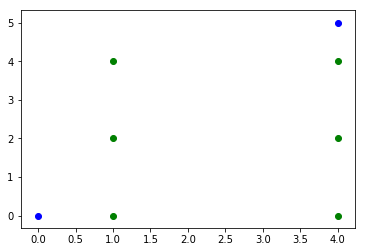

In [4]:
plot_train_test_data(X_train, X_test)

## Scikit-Learn

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

```python
class sklearn.cluster.KMeans(n_clusters=8, init='k-means++',
                             n_init=10, max_iter=300,
                             tol=0.0001, precompute_distances='auto',
                             verbose=0, random_state=None,
                             copy_x=True, n_jobs=1,
                             algorithm='auto')
```

In [5]:
# Example usage of KMeans in Scikit-Learn
from sklearn.cluster import KMeans as KMeansScikit

kmeans = KMeansScikit(n_clusters=2, random_state=0).fit(X_train)

In [6]:
# The first 3 points belong to the first cluster.
# The rest belong the the second cluster.
kmeans.labels_

array([0, 0, 0, 1, 1, 1], dtype=int32)

In [7]:
kmeans.predict(X_test)

array([0, 1], dtype=int32)

array([[ 1.,  2.],
       [ 4.,  2.]])

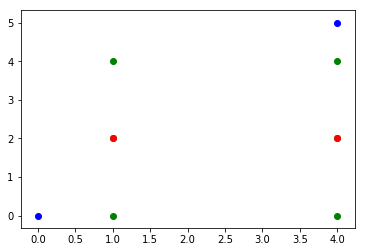

In [8]:
# green train data
# blue test data
# red cluster centers
plot_train_test_center(X_train, X_test, kmeans.cluster_centers_)
kmeans.cluster_centers_

## Our implementation

```python
class KMeans(n_clusters=8,
             init='random',
             n_init=10,
             max_iter=300,
             tol=0.0001)
```

In [9]:
class KMeans:
    def __init__(self, n_clusters=8, init="random", n_init=10, max_iter=300, tol=0.0001):
        if n_clusters < 2:
            raise ValueError("n_clusters < 2")
            
        self.n_clusters = n_clusters
        self.init       = init
        self.n_init     = n_init
        self.max_iter   = max_iter
        self.tol        = tol        
        
        self.cluster_centers_ = []
        self.labels_          = []
        
        # sum of distances of samples to their closest cluster center
        self.inertia_         = 0
        
    def fit(self, X):
        pass # TODO
    
    def predict(self, X):
        pass # TODO

### Cluster simple dataset

In [10]:
# kmeans = KMeans(n_clusters=2).fit(X_train)
# kmeans.labels_
# plot_train_test_center(X_train, X_test, kmeans.cluster_centers_)
# kmeans.cluster_centers_
# kmeans.predict(X_test)

### Cluster harder dataset

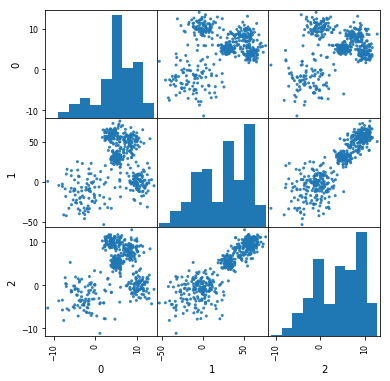

In [11]:
from pandas.plotting import scatter_matrix
df = pd.read_csv("dataset.csv", header=-1) # 3-dimensional dataset
scatter_matrix(df, alpha=0.9, figsize=(6, 6))

# use for clustering
X_harder = np.array(df)